# sklearn.ensemble.GradientBoostingClassifier
* class sklearn.ensemble.GradientBoostingClassifier(*, loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# features.txt 파일에는 피처 이름 indx와 피처명이 공백으로 분리되어 있음. 이를 DataFrame으로 로드
feature_name_df = pd.read_csv('./datasets/features.txt', sep='\s+', header=None, names=['column_index', 'column_name'])

# 피처명 index를 제거하고, 피처명만 리스트 객체로 생성한 뒤 샘플로 10개만 추출
feature_name = feature_name_df.iloc[:,1].values.tolist()
print(f'천체 피처명에서 10개만 추출 : {feature_name[:10]}')

천체 피처명에서 10개만 추출 : ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


In [2]:
feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index']>1].count())
feature_dup_df[feature_dup_df['column_index']>1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


In [3]:
# 원본 데이터에 중복된 feature 명으로 인하여 신규 버전의 pandas에서 duplicate name 에러를 발생
# 중복 feature 명에 대해서 원본 feature 명에 '_1(또는2)'를 추가로 부여하는 함수 get_new_feature_name_df() 생성

def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x: x[0]+'_'+str(x[1]) if x[1]>0 else x[0], axis =1)
    new_feature_name_df = new_feature_name_df.drop(['index'],axis=1)
    return new_feature_name_df

In [4]:
import pandas as pd

def get_human_dataset():

    # 각 데이터 파일들을 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당
    feature_name_df = pd.read_csv('./datasets/features.txt', sep='\s+', header=None, names=['column_index', 'column_name'])

    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame 생성
    new_feature_name_df = get_new_feature_name_df(feature_name_df)

    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:,1].values.tolist()

    # 학습 피처 데이터 셋과 테스트 피처 데이터를 DataFrame 으로 로딩, 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./datasets/train/X_train.txt', sep='\s+', names=feature_name)
    X_test = pd.read_csv('./datasets/test/X_test.txt', sep='\s+', names=feature_name)

    # 학습 레이블과 테스트 레이블 데이터를 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('./datasets/train/y_train.txt', sep='\s+', header=None, names=['action'])
    y_test = pd.read_csv('./datasets/test/y_test.txt', sep='\s+', header=None, names=['action'])

    # 로드된 학습/테스트용 DataFrame을 모두 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

In [8]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
from sklearn.metrics import accuracy_score
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

# GBM 수행 시간 측정을 위함. 시작 시간 설정.
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print(f'GBM 정확도 : {gb_accuracy:.4f}')
print(f'GBM 수행 시간 : {time.time()-start_time:.1f}')

GBM 정확도 : 0.9389
GBM 수행 시간 : 972.6


In [ ]:
from sklearn.model_selection import GridSearchCV
params = {
    'n_estimators' : [100, 500],
    'learning_rate' : [0.05, 0.1]
}
grid_cv = GridSearchCV(gb_clf, param_grid=params, cv=2, verbose=1)
grid_cv.fit(X_train, y_train)
print(f"최적 하이퍼 파라미터 : {grid_cv.best_params_}")
print(f"최고 예측 정확도 : {grid_cv.best_score_:.4f}")

In [15]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features = dataset.data
y_labels = dataset.target

cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target'] = y_labels

cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [2]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.3, random_state=126)

In [11]:
xgb_clt = XGBClassifier(n_estimators = 400, learning_rate=0.1, max_depth=3)
xgb_clt.fit(X_train,y_train)
pred = xgb_clt.predict(X_test)
pred_proba = xgb_clt.predict_proba(X_test)

[13:32:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [25]:
def get_clt_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    F1 = f1_score(y_test, pred)
    AUC = roc_auc_score(y_test, pred)
    lr_probs = pred_proba[:, 1]

    # Calculate roc curves    
    ns_probs = [0 for _ in range(len(y_test))]
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

    # plot the roc curve for the model
    plt.figure(facecolor='w')
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label = 'No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label = 'XGBOOST')

    # axis labels
    plt.xlabel('False Positve Rate')
    plt.ylabel('True Positive Rate')

    # show the legend
    plt.legend()

    # show the plot
    plt.show()


    print(f'오차행렬 \n{confusion}')
    print(f'정확도 \n{accuracy:.4f}')
    print(f'정밀도 \n{precision:.4f}')
    print(f'재현율 \n{recall:.4f}')
    print(f'f1_score \n{F1:.4f}')
    print(f'AUC \n{AUC:.4f}')


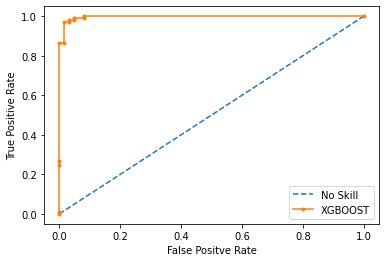

오차행렬 
[[ 58   4]
 [  1 108]]
정확도 
0.9708
정밀도 
0.9643
재현율 
0.9908
f1_score 
0.9774
AUC 
0.9632


In [26]:
get_clt_eval(y_test, pred)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

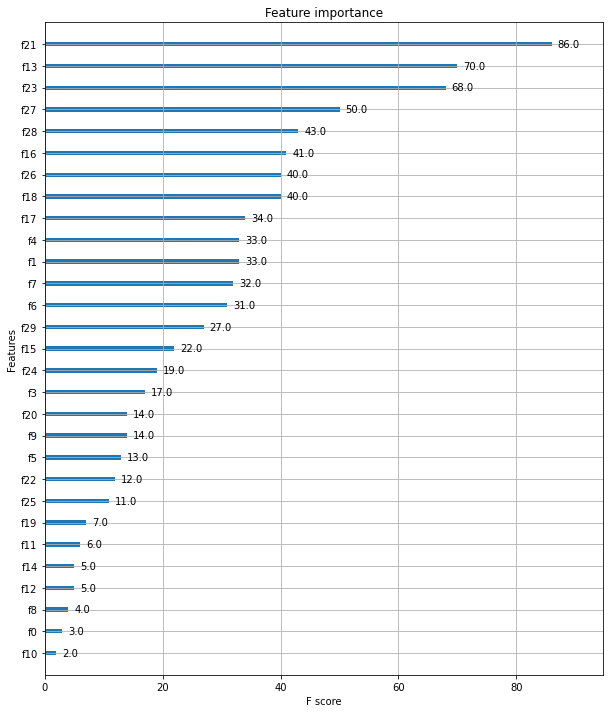

In [27]:
fig, ax = plt.subplots(figsize=(10,12), facecolor='w')

plot_importance(xgb_clt, ax=ax)

In [28]:
xgb_clt = XGBClassifier(n_estimators = 400, learning_rate=0.1, max_depth=3)

xgb_clt.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss', eval_set=[(X_test,y_test)], verbose=True)

pred = xgb_clt.predict(X_test)
pred_proba = xgb_clt.predict_proba(X_test)
ns_probs = [0 for _ in range(len(y_test))]
roc_curve(y_test, ns_probs)

[0]	validation_0-logloss:0.61478
[1]	validation_0-logloss:0.54958
[2]	validation_0-logloss:0.49824
[3]	validation_0-logloss:0.45383
[4]	validation_0-logloss:0.41471
[5]	validation_0-logloss:0.38285
[6]	validation_0-logloss:0.35442
[7]	validation_0-logloss:0.33043
[8]	validation_0-logloss:0.30884
[9]	validation_0-logloss:0.28752
[10]	validation_0-logloss:0.26886
[11]	validation_0-logloss:0.25489
[12]	validation_0-logloss:0.23888
[13]	validation_0-logloss:0.22526
[14]	validation_0-logloss:0.21423
[15]	validation_0-logloss:0.20274
[16]	validation_0-logloss:0.19406
[17]	validation_0-logloss:0.18565
[18]	validation_0-logloss:0.17795
[19]	validation_0-logloss:0.17006
[20]	validation_0-logloss:0.16235
[21]	validation_0-logloss:0.15660
[22]	validation_0-logloss:0.15023
[23]	validation_0-logloss:0.14447
[24]	validation_0-logloss:0.13882
[25]	validation_0-logloss:0.13479
[26]	validation_0-logloss:0.13130
[27]	validation_0-logloss:0.12822
[28]	validation_0-logloss:0.12393
[29]	validation_0-loglos

(array([0., 1.]), array([0., 1.]), array([1, 0]))

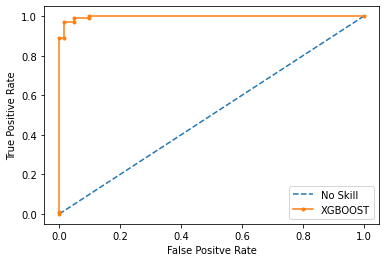

오차행렬 
[[ 57   5]
 [  1 108]]
정확도 
0.9649
정밀도 
0.9558
재현율 
0.9908
f1_score 
0.9730
AUC 
0.9551


In [29]:
get_clt_eval(y_test, pred)

# sklearn.svm.SVC
* class sklearn.svm.SVC(*, C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=- 1, decision_function_shape='ovr', break_ties=False, random_state=None)

In [32]:
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)


clf = svm.SVC(gamma=0.001, C=100)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

print(f'SVM 정확도 : {accuracy_score(y_test, pred):.4f}')

SVM 정확도 : 0.9600


# sklearn.neighbors.KNeighborsClassifier
* class sklearn.neighbors.KNeighborsClassifier(n_neighbors=5, *, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)

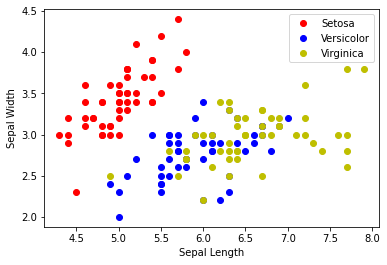

In [33]:
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

iris = load_iris()
sepal = iris.data[:, 0:2]
kind = iris.target

plt.figure(facecolor='w')
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')

plt.plot(sepal[kind == 0][:,0], sepal[kind == 0][:,1], "ro", label = 'Setosa')
plt.plot(sepal[kind == 1][:,0], sepal[kind == 1][:,1], "bo", label = 'Versicolor')
plt.plot(sepal[kind == 2][:,0], sepal[kind == 2][:,1], "yo", label = 'Virginica')

plt.legend()


In [34]:
from sklearn.model_selection import train_test_split

X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=4)

In [35]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
scores = accuracy_score(y_test, y_pred)
scores

0.9666666666666667

In [36]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X,y)

classes = {0 : 'setosa', 1 : 'versicolor', 2 : 'virginica'}

# 새로운 데이터 대입
x_new = [[3,4,5,2],[5,4,2,2]]
y_predict = knn.predict(x_new)

print(classes[y_predict[0]])
print(classes[y_predict[1]])

versicolor
setosa
